In [2]:
import geopandas as gpd
import shapefile as shp
import matplotlib.pyplot as plt
import pandas as pd
import rtree
import seaborn as sns
import matplotlib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [4]:
dates = ['201101', '201104', '201107', '201110', 
       '201201', '201204', '201207', '201210', '201301', '201304', '201307', '201310', '201401', '201404', '201407',
       '201410', '201501', '201504', '201507', '201510', '201602', '201606','201610',
       '201706', '201710', '201802', '201806', '201810', '201812','201902', '201906', '201910']

In [5]:
def set_color(cs):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010'}
    if cs in color_map.keys():
        return color_map[cs]
    else:
        return '#CCCCCC'

In [6]:
cs = pd.read_csv('ethiopia_admin2_fewsnet_2020-05-05.csv')
ml1 = pd.read_csv('ethiopia_admin2_fewsnet_ML12020-05-05.csv')
ml2 = pd.read_csv('ethiopia_admin2_fewsnet_ML22020-05-05.csv')

In [7]:
merged = cs.merge(ml1[['date', 'ADMIN2', 'ML1']], on=['ADMIN2', 'date'], how='left')
merged = merged.merge(ml2[['date', 'ADMIN2', 'ML2']], on=['ADMIN2', 'date'], how='left')
merged.sort_values('date')

,Unnamed: 0,date,ADMIN0,ADMIN1,ADMIN2,CS,ML1,ML2
2773,4136,2009-07-01,Ethiopia,SNNPR,Bench Maji,2.000,1.000,1.000
2757,4172,2009-07-01,Ethiopia,Gambela,Itang,2.000,3.000,2.000
2758,6199,2009-07-01,Ethiopia,Benshangul Gumuz,Mao-Komo,1.000,1.000,1.000
2759,4174,2009-07-01,Ethiopia,Gambela,Agniwak,2.000,3.000,2.000
2760,4233,2009-07-01,Ethiopia,Oromia,East Hararge,3.000,3.000,2.000
...,...,...,...,...,...,...,...,...
1010,2651,2019-10-01,Ethiopia,Benshangul Gumuz,Mao-Komo,1.000,1.000,1.000
1009,2650,2019-10-01,Ethiopia,Gambela,Itang,1.000,1.000,1.000
1008,842,2019-10-01,Ethiopia,Somali,Shebelle,3.000,2.000,2.000
1006,1770,2019-10-01,Ethiopia,Afar,Awusi,2.000,2.000,2.000


In [8]:
# eth pop: fewsnet
admin2_mapping = {'Zone 1 (Awsi Rasu)': 'Awusi', 'Zone 2 (Kilbet Rasu)': 'Kilbati', 'Zone 3 (Gabi Rasu)': 'Gabi',
                 'Zone 4  (Fantana Rasu)': 'Fanti', 'Zone 5 (Hari Rasu)': 'Khari', 'Central': 'Central Tigray',
                 'Eastern': 'East Tigray', 'North Western': 'Northwest Tigray', 'South Eastern': 'Southeast Tigray',
                 'Western': 'West Tigray', 'Southern': 'South Tigray', 'Mejenger': 'Mezhenger', 'Nuwer': 
                 'Nuer', 'Etang Special': 'Itang', 'Agnewak': 'Agniwak', 'Dire Dawa rural': 'Dire Dawa', 
                  'Dire Dawa urban': 'Dire Dawa', 'North Wello': 'North Wollo', 'Wag Hamra': 'Wag Himra',
                 'Liban': 'Liben', 'Siti': 'Sitti', 'Shabelle': 'Shebelle', 'Doolo': 'Dollo', 'Mao Komo': 'Mao-Komo',
                 'Halaba Special': 'Alaba', 'Gamo': 'Gamo Gofa', 'Gofa': 'Gamo Gofa', 'Guraghe': 'Gurage',
                 'Kefa': 'Keffa', 'Dawuro': 'Dawro', 'Ilu Aba Bora': 'Ilubabor'}

admin1_mapping = {'SNNP': 'SNNPR'}

def get_new_name(name, n_dict):
    if name in n_dict.keys():
        return n_dict[name]
    else:
        return name

In [9]:
# import population data
eth_pop = pd.read_csv('eth_admpop_adm2_2020.csv')
eth_pop['admin2Name_en'] = eth_pop['admin2Name_en'].apply(lambda x: get_new_name(x, admin2_mapping))
eth_pop['admi12Name_en'] = eth_pop['admin1Name_en'].apply(lambda x: get_new_name(x, admin1_mapping))
        
eth_pop.head()

,admin2Name_en,admin2Pcode,admin1Name_en,admin1Pcode,admin0Name_en,admin0Pcode,Total,Male,Female,T_00_17,T_18_60,T_60plus,admi12Name_en
0,Afder,ET0508,Somali,ET05,Ethiopia,ET,654828,352416,302413,347059,276010,31759,Somali
1,Agniwak,ET1202,Gambela,ET12,Ethiopia,ET,164054,83695,80359,86948,69149,7957,Gambela
2,Alle,ET0712,SNNP,ET07,Ethiopia,ET,81190,40595,40595,43031,34221,3938,SNNPR
3,Amaro,ET0721,SNNP,ET07,Ethiopia,ET,195252,97626,97626,103484,82299,9470,SNNPR
4,Arsi,ET0408,Oromia,ET04,Ethiopia,ET,3645492,1829539,1815952,1932111,1536575,176806,Oromia


In [10]:
pop_dict = {'2009': 11500000, '2010': 11890000, '2011': 12290000, '2012': 12710000, '2013': 13130000,
           '2014': 13570000, '2015': 14010000, '2016': 14450000, '2017': 14900000, '2018': 14900000,
           '2019': 14900000, '2020': 14900000}

# estimate percentage of population at given year in relation to 2020 estimate
perc_dict = {k: v/pop_dict['2020'] for k, v in pop_dict.items()}

print(perc_dict)

{'2009': 0.7718120805369127, '2010': 0.797986577181208, '2011': 0.8248322147651007, '2012': 0.8530201342281879, '2013': 0.8812080536912752, '2014': 0.9107382550335571, '2015': 0.9402684563758389, '2016': 0.9697986577181208, '2017': 1.0, '2018': 1.0, '2019': 1.0, '2020': 1.0}


In [11]:
# JP: adjustment = estimates of past populations based on 2020 estimate??
merged['date'] = pd.to_datetime(merged['date'])

def get_adjusted(row):
    year = str(row['date'].year)
    adjustment = perc_dict[year]
    return row['Total']*adjustment

In [12]:
# JP: CS, ML1 and ML2 here: interpolations of the phase of the largest portion of population?
merged = merged.merge(eth_pop[['admin2Name_en', 'Total']], how='left', left_on='ADMIN2', right_on='admin2Name_en')
merged['adjusted_population'] = merged.apply(get_adjusted, axis=1)
#['Total'].apply(lambda x: x*perc_dict[merged['date'].dt.year]
merged.head()

,Unnamed: 0,date,ADMIN0,ADMIN1,ADMIN2,CS,ML1,ML2,admin2Name_en,Total,adjusted_population
0,1373,2019-02-01,Ethiopia,SNNPR,Segen,2.000,3.000,2.000,NaN,nan,nan
1,6004,2019-02-01,Ethiopia,Oromia,Bale,2.000,3.000,2.000,Bale,1887498.000,1887498.000
2,1375,2019-02-01,Ethiopia,Oromia,Borena,2.000,2.000,2.000,Borena,545493.000,545493.000
3,3,2019-02-01,Ethiopia,Somali,Jarar,3.000,3.000,3.000,Jarar,641077.000,641077.000
4,1930,2019-02-01,Ethiopia,Oromia,East Wellega,1.000,1.000,1.000,East Wellega,1693681.000,1693681.000


In [18]:
merged['cs_1'] = np.where(merged['CS']==1, merged['adjusted_population'], 0)
merged['cs_2'] = np.where(merged['CS']==2, merged['adjusted_population'], 0)
merged['cs_3'] = np.where(merged['CS']==3, merged['adjusted_population'], 0)
merged['cs_4'] = np.where(merged['CS']==4, merged['adjusted_population'], 0)
merged['ml_1_1'] = np.where(merged['ML1']==1, merged['adjusted_population'], 0)
merged['ml_1_2'] = np.where(merged['ML1']==2, merged['adjusted_population'], 0)
merged['ml_1_3'] = np.where(merged['ML1']==3, merged['adjusted_population'], 0)
merged['ml_1_4'] = np.where(merged['ML1']==4, merged['adjusted_population'], 0)
merged['ml_2_1'] = np.where(merged['ML2']==1, merged['adjusted_population'], 0)
merged['ml_2_2'] = np.where(merged['ML2']==2, merged['adjusted_population'], 0)
merged['ml_2_3'] = np.where(merged['ML2']==3, merged['adjusted_population'], 0)
merged['ml_2_4'] = np.where(merged['ML2']==4, merged['adjusted_population'], 0)
merged.head()

,Unnamed: 0,date,ADMIN0,ADMIN1,ADMIN2,CS,ML1,ML2,admin2Name_en,Total,...,cs_3,cs_4,ml_1_1,ml_1_2,ml_1_3,ml_1_4,ml_2_1,ml_2_2,ml_2_3,ml_2_4
0,1373,2019-02-01,Ethiopia,SNNPR,Segen,2.000,3.000,2.000,NaN,nan,...,0.000,0.000,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000
1,6004,2019-02-01,Ethiopia,Oromia,Bale,2.000,3.000,2.000,Bale,1887498.000,...,0.000,0.000,0.000,0.000,1887498.000,0.000,0.000,1887498.000,0.000,0.000
2,1375,2019-02-01,Ethiopia,Oromia,Borena,2.000,2.000,2.000,Borena,545493.000,...,0.000,0.000,0.000,545493.000,0.000,0.000,0.000,545493.000,0.000,0.000
3,3,2019-02-01,Ethiopia,Somali,Jarar,3.000,3.000,3.000,Jarar,641077.000,...,641077.000,0.000,0.000,0.000,641077.000,0.000,0.000,0.000,641077.000,0.000
4,1930,2019-02-01,Ethiopia,Oromia,East Wellega,1.000,1.000,1.000,East Wellega,1693681.000,...,0.000,0.000,1693681.000,0.000,0.000,0.000,1693681.000,0.000,0.000,0.000


In [19]:
cols = ['cs_1', 'cs_2', 'cs_3', 'cs_4', 'ml_1_1', 'ml_1_2', 'ml_1_3', 'ml_1_4', 'ml_2_1', 'ml_2_2', 'ml_2_3', 'ml_2_4']

In [20]:
def get_previous_3(row, df):
    date = row['date']
    try:
        previous =  row['date'] + pd.DateOffset(months=-3)
        previous_row = df.loc[(df['date']==previous)&(df['ADMIN1']==row['ADMIN1'])&(df['ML1']==row['ML1'])]
        return previous_row['adjusted_population']
    except:
        return None
    
def get_previous_6(row, df):
    date = row['date']
    try:
        previous =  row['date'] + pd.DateOffset(months=-6)
        previous_row = df.loc[(df['date']==previous)&(df['ADMIN1']==row['ADMIN1'])&(df['ML2']==row['CS'])]
        return previous_row['adjusted_population']
    except:
        return None

In [21]:
def get_trigger_1(row):
    if row['total_pop'] == 0:
        return 0
    if row['cs_3'] + row['cs_4'] >= row['total_pop']/5:
        return 1
    else:
        return 0
    
def get_trigger_2(row):
    if row['total_pop'] == 0:
        return 0
    if row['ml_1_3'] + row['ml_1_4'] >= row['total_pop']/20:
        return 1
    else:
        return 0
    
def get_trigger_3(row):
    if row['total_pop'] == 0:
        return 0
    if row['ml_1_4'] >= row['total_pop']/40:
        return 1
    else:
        return 0
    
def get_trigger_4(row):
    if row['total_pop'] == 0:
        return 0
    if row['ml_1_3'] + row['ml_1_4'] >= row['total_pop']/3.33:
        return 1
    else:
        return 0
    

In [22]:
grouped = merged[['date', 'ADMIN1']+cols].groupby(['date', 'ADMIN1']).agg('sum').reset_index()
grouped['total_pop'] = grouped['cs_1']+grouped['cs_2']+grouped['cs_3']+grouped['cs_4']
grouped['trigger_1'] = grouped.apply(get_trigger_1, axis=1)
grouped['trigger_2'] = grouped.apply(get_trigger_2, axis=1)
grouped['trigger_3'] = grouped.apply(get_trigger_3, axis=1)
grouped['trigger_4'] = grouped.apply(get_trigger_4, axis=1)
grouped.head()

,date,ADMIN1,cs_1,cs_2,cs_3,cs_4,ml_1_1,ml_1_2,ml_1_3,ml_1_4,ml_2_1,ml_2_2,ml_2_3,ml_2_4,total_pop,trigger_1,trigger_2,trigger_3,trigger_4
0,2009-07-01,Addis Ababa,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0
1,2009-07-01,Afar,0.000,217154.732,1252695.000,0.000,0.000,217154.732,1252695.000,0.000,0.000,378773.725,1091076.007,0.000,1469849.732,1,1,0,1
2,2009-07-01,Amhara,5904160.973,3025491.007,2181605.570,0.000,5904160.973,3025491.007,2181605.570,0.000,3953820.403,7157437.148,0.000,0.000,11111257.550,0,1,0,0
3,2009-07-01,Benshangul Gumuz,796845.805,0.000,0.000,0.000,796845.805,0.000,0.000,0.000,796845.805,0.000,0.000,0.000,796845.805,0,0,0,0
4,2009-07-01,Dire Dawa,0.000,392789.060,0.000,0.000,0.000,392789.060,0.000,0.000,0.000,392789.060,0.000,0.000,392789.060,0,0,0,0


In [23]:
total_pop = grouped[['date', 'ADMIN1']].groupby(['date','ADMIN1']).agg('sum').reset_index()
#total_pop['perc_20'] = total_pop['adjusted_population']/5
#total_pop['perc_10'] = total_pop['adjusted_population']/10
total_pop.head()

,date,ADMIN1
0,2009-07-01,Addis Ababa
1,2009-07-01,Afar
2,2009-07-01,Amhara
3,2009-07-01,Benshangul Gumuz
4,2009-07-01,Dire Dawa


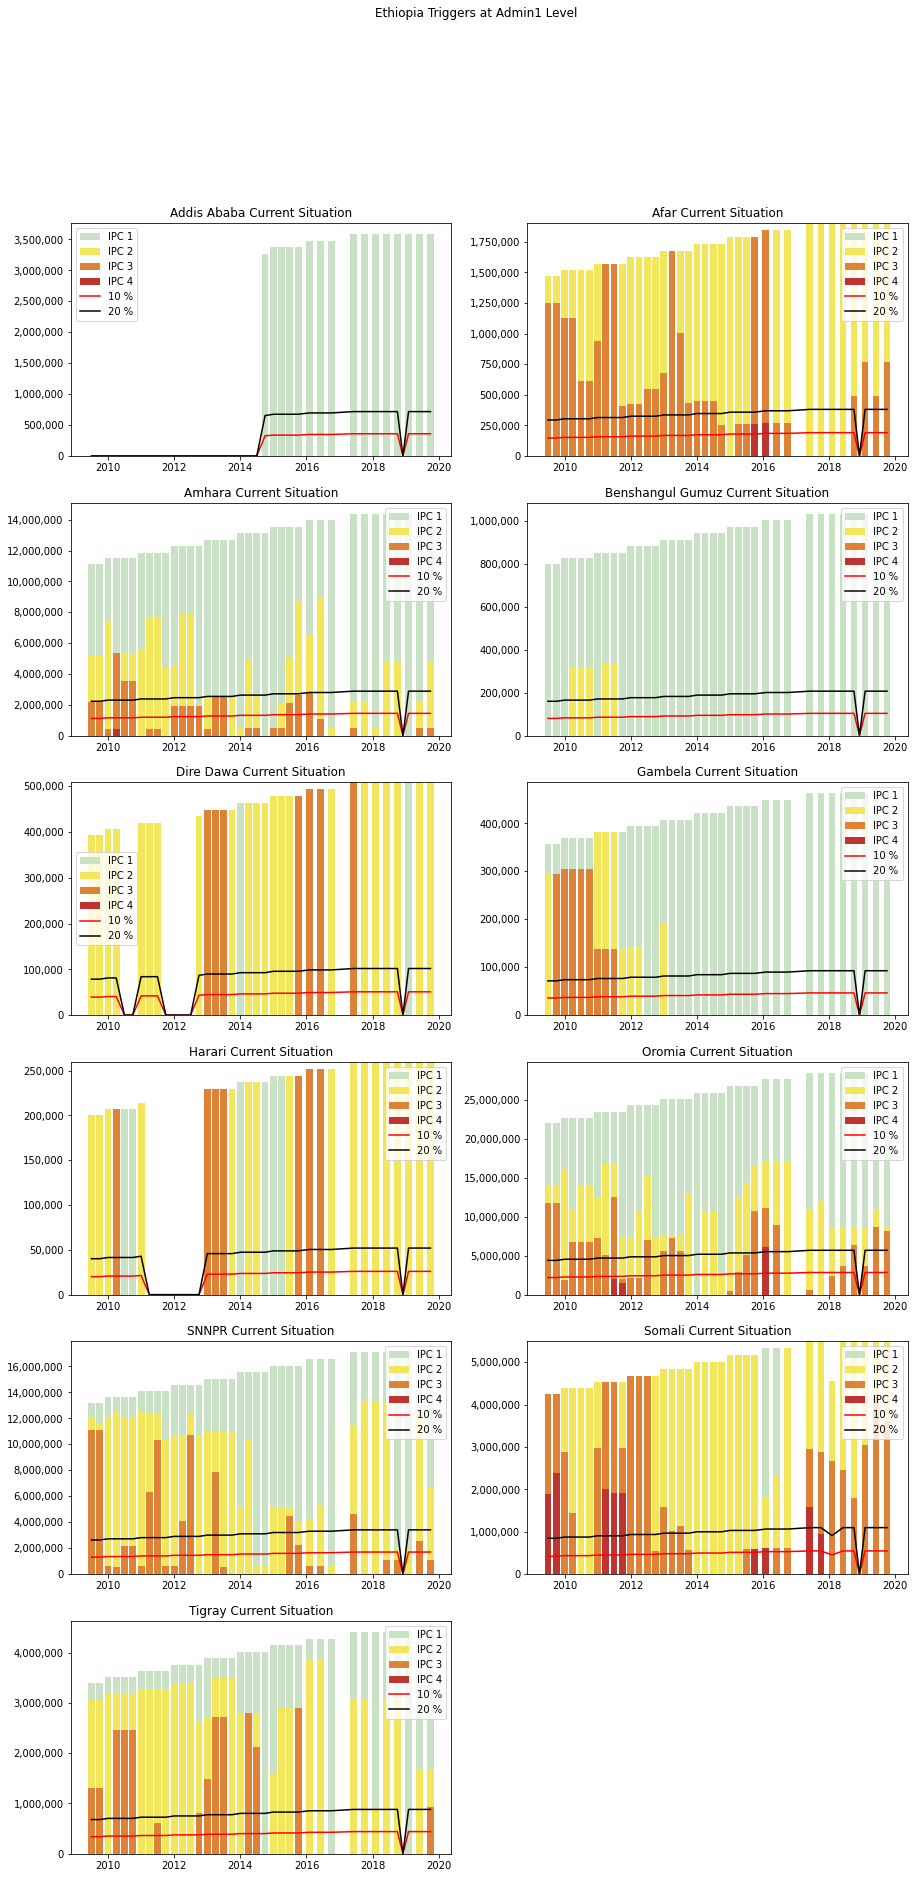

In [24]:
color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
width = 75
count = 1
fig, ax = plt.subplots(figsize=(15,30))
plt.suptitle('Ethiopia Triggers at Admin1 Level')
for region in grouped['ADMIN1'].unique():
    ax = plt.subplot(6,2,count)
    data = grouped.loc[grouped['ADMIN1']==region]
    pop_data = total_pop.loc[total_pop['ADMIN1']==region]
    total = data['cs_1']+data['cs_2']+data['cs_3']+data['cs_4'].to_numpy()
    p4 = plt.bar(data['date'], data['cs_4'], width=width, color=color_map[4])
    p3 = plt.bar(data['date'], data['cs_3'], width=width, color=color_map[3], bottom=data['cs_4'].to_numpy())
    p2 = plt.bar(data['date'], data['cs_2'], width=width, color=color_map[2], bottom=(data['cs_3']+data['cs_4']).to_numpy())
    p1 = plt.bar(data['date'], data['cs_1'], width=width, color=color_map[1], bottom=(data['cs_2']+data['cs_3']+data['cs_4']).to_numpy())
    p5 = plt.plot(pop_data['date'], total/10 , color='red')
    p6 = plt.plot(pop_data['date'], total/5, color='black')
    plt.title(region + ' Current Situation')
    ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('IPC 1', 'IPC 2', 'IPC 3', 'IPC 4', '10 %', '20 %'))
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    count+=1

In [25]:
# Study of subnational triggers

In [26]:
shape = 'ET_Admin2_2014/ET_Admin2_2014.shp'
gdf = gpd.read_file(shape)
gdf.head()

,FNID,EFF_YEAR,COUNTRY,ADMIN0,ADMIN1,ADMIN1FR,ADMIN1SP,ADMIN1PT,ADMIN2,ADMIN2FR,ADMIN2SP,ADMIN2PT,ALIASES,geometry
0,ET2014A20722,2014,ET,Ethiopia,SNNPR,None,None,None,Segen,None,None,None,None,"POLYGON ((37.00893 5.20392, 37.00860 5.21044, ..."
1,ET2014A20411,2014,ET,Ethiopia,Oromia,None,None,None,Bale,None,None,None,None,"POLYGON ((41.52576 7.95226, 41.52766 7.94139, ..."
2,ET2014A20708,2014,ET,Ethiopia,SNNPR,None,None,None,Sheka,None,None,None,None,"POLYGON ((35.60882 7.81575, 35.60975 7.81142, ..."
3,ET2014A20412,2014,ET,Ethiopia,Oromia,None,None,None,Borena,None,None,None,None,"POLYGON ((37.91887 6.58472, 37.92165 6.57858, ..."
4,ET2014A20704,2014,ET,Ethiopia,SNNPR,None,None,None,Sidama,None,None,None,None,"POLYGON ((39.12953 6.33941, 39.12851 6.32545, ..."


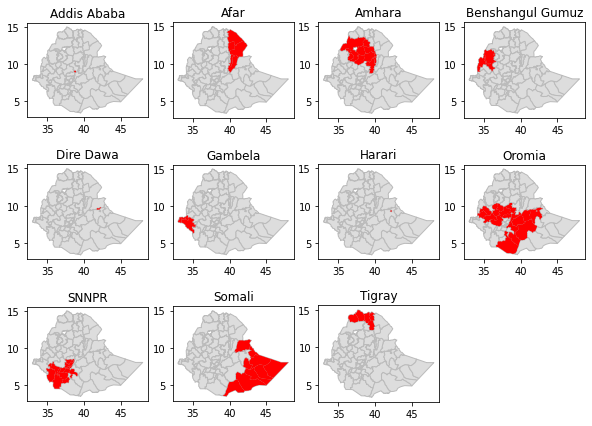

In [27]:
# JP BELOW: location of each region, no metric visualized

count = 1
f, ax = plt.subplots(figsize=(10,10))
for region in grouped['ADMIN1'].unique():
    ax2 = plt.subplot(4, 4, count)
    gdf.plot(ax=ax2, column='ADMIN0', color='#DDDDDD', edgecolor='#BBBBBB')
    gdf.loc[gdf['ADMIN1']==region].plot(ax=ax2,color='red')
    plt.title(region)
    count+=1
plt.show()

In [28]:
# JP new_trigger = cs at ipc-3-4 >= 20% pop (T1) and ML1 at 4 >= 2.5% pop (T3) subnational
new_trigger = grouped.loc[(grouped['trigger_1']==1)&(grouped['trigger_3']==1)]
new_trigger['date'] = pd.to_datetime(new_trigger['date'])
new_trigger['year'] = new_trigger['date'].apply(lambda x: x.year)
#JP addition:
new_trigger['month'] = new_trigger['date'].dt.month

# JP new_trigger_30 = ML1 (30 days) at 3 and 4 is >= 33.33% pop (T4)
new_trigger_30 = grouped.loc[(grouped['trigger_4']==1)]
new_trigger_30['date'] = pd.to_datetime(new_trigger_30['date'])
new_trigger_30['year'] = new_trigger_30['date'].apply(lambda x: x.year)

#jp addition:
new_trigger_30['month'] = new_trigger_30['date'].dt.month


In [29]:
new_trigger.head()

,date,ADMIN1,cs_1,cs_2,cs_3,cs_4,ml_1_1,ml_1_2,ml_1_3,ml_1_4,...,ml_2_2,ml_2_3,ml_2_4,total_pop,trigger_1,trigger_2,trigger_3,trigger_4,year,month
9,2009-07-01,Somali,0.000,0.000,2351664.329,1885877.282,0.000,0.000,1846260.168,2391281.443,...,1456348.423,895315.906,1885877.282,4237541.611,1,1,1,1,2009,7
23,2010-01-01,Afar,0.000,391619.095,1128077.715,0.000,0.000,0.000,1006562.713,513134.097,...,0.000,1295177.700,224519.109,1519696.809,1,1,1,1,2010,1
27,2010-01-01,Gambela,65129.270,0.000,304204.453,0.000,65129.270,0.000,0.000,304204.453,...,0.000,0.000,304204.453,369333.723,1,1,1,1,2010,1
31,2010-01-01,Somali,0.000,1505737.630,2875511.913,0.000,0.000,0.000,3118892.234,1262357.310,...,0.000,3867175.419,514074.125,4381249.544,1,1,1,1,2010,1
35,2010-04-01,Amhara,6104389.041,0.000,4971559.316,412125.754,6104389.041,0.000,4971559.316,412125.754,...,1843464.701,5144577.170,412125.754,11488074.111,1,1,1,1,2010,4


In [30]:
# JP reproduce table of past subnational trigger firings (see below for clearer format)
list(new_trigger['year'].groupby(new_trigger['ADMIN1']))
list(new_trigger['ADMIN1'].groupby(new_trigger['year']))

[(2009,
  9    Somali
  Name: ADMIN1, dtype: object),
 (2010,
  23       Afar
  27    Gambela
  31     Somali
  35     Amhara
  Name: ADMIN1, dtype: object),
 (2011,
  86    Somali
  95    Oromia
  97    Somali
  Name: ADMIN1, dtype: object),
 (2015,
  276    Afar
  Name: ADMIN1, dtype: object),
 (2016,
  287      Afar
  293    Oromia
  Name: ADMIN1, dtype: object),
 (2017,
  328    Somali
  339    Somali
  Name: ADMIN1, dtype: object)]

In [45]:
# JP add months to table of past triggers SUBNATIONAL
new_trigger.groupby(['year', 'month'], as_index=False)['ADMIN1'].agg(lambda x: list(x))

,year,month,ADMIN1
0,2009,7,[Somali]
1,2010,1,"[Afar, Gambela, Somali]"
2,2010,4,[Amhara]
3,2011,4,[Somali]
4,2011,7,"[Oromia, Somali]"
5,2015,10,[Afar]
6,2016,2,"[Afar, Oromia]"
7,2017,6,[Somali]
8,2017,10,[Somali]


In [32]:
count = 1
f, ax = plt.subplots(figsize=(12,12))
for d in ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
    ax2 = plt.subplot(4, 4, count)
    gdf.plot(ax=ax2, column='ADMIN0', color='#DDDDDD', edgecolor='#BBBBBB')
    regions = new_trigger['ADMIN1'].loc[new_trigger['year'].astype(str)==d]
    print(d, regions)
    gdf.loc[gdf['ADMIN1'].isin(regions)].plot(ax=ax2, color='red')
    plt.title("Regions triggered \n"+str(d)+' (20%)')
    count+=1
plt.show()

2009 9    Somali
Name: ADMIN1, dtype: object
2010 23       Afar
27    Gambela
31     Somali
35     Amhara
Name: ADMIN1, dtype: object
2011 86    Somali
95    Oromia
97    Somali
Name: ADMIN1, dtype: object
2012 Series([], Name: ADMIN1, dtype: object)


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

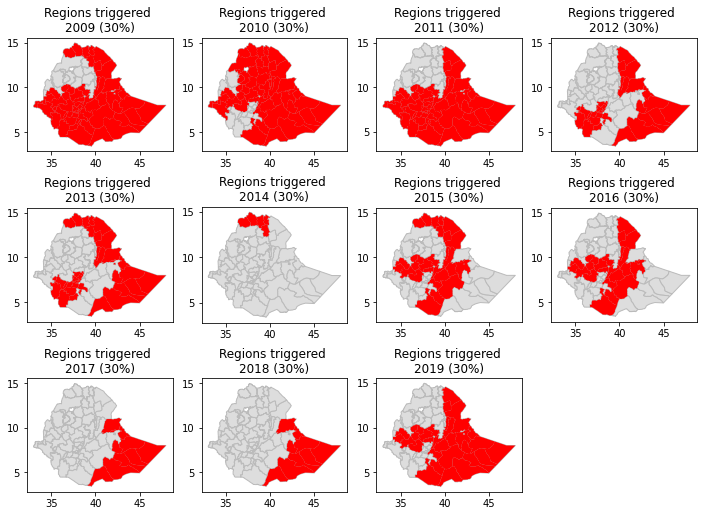

In [33]:
count = 1
f, ax = plt.subplots(figsize=(12,12))
for d in ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
    ax2 = plt.subplot(4, 4, count)
    gdf.plot(ax=ax2, column='ADMIN0', color='#DDDDDD', edgecolor='#BBBBBB')
    regions = new_trigger_30['ADMIN1'].loc[new_trigger_30['year'].astype(str)==d]
    gdf.loc[gdf['ADMIN1'].isin(regions)].plot(ax=ax2, color='red')
    plt.title("Regions triggered \n"+str(d)+' (30%)')
    count+=1
plt.show()

In [34]:
count = 1
f, ax = plt.subplots(figsize=(12,12))
for d in ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
    ax2 = plt.subplot(4, 4, count)
    gdf.plot(ax=ax2, column='ADMIN0', color='#DDDDDD', edgecolor='#BBBBBB')
    regions = new_trigger['ADMIN1'].loc[new_trigger['year'].astype(str)==d].unique()
    if len(regions) > 1:
        gdf.loc[gdf['ADMIN1'].isin(regions)].plot(ax=ax2, color='red')
        plt.title("Regions triggered \n"+str(d)+' (20%)')
    else:
        gdf.loc[gdf['ADMIN1'].isin(regions)].plot(ax=ax2, color='orange')
        plt.title("Regions not triggered \n"+str(d)+' (20%)')
    count+=1
plt.show()

ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

In [35]:
def get_pop(date):
    d = str(date).split('-')
    if '2009' in d:
        return 11500000
    elif '2010' in d:
        return 11890000
    elif '2011' in d:
        return 12290000
    elif '2012' in d:
        return 12710000
    elif '2013' in d:
        return 13130000
    elif '2014' in d:
        return 13570000
    elif '2015' in d:
        return 14010000
    elif '2016' in d:
        return 14450000
    else:
        return 14900000

In [36]:
total_pop = pd.DataFrame(columns=['date', 'total_pop'])
total_pop['date'] = grouped['date'].unique()
total_pop['total_pop'] = total_pop['date'].apply(lambda x: get_pop(x))
total_pop['perc_20'] = total_pop['total_pop']/5 # 20% threshold
total_pop['perc_10'] = total_pop['total_pop']/10 # 20% threshold
total_pop['perc_5'] = total_pop['total_pop']/20 # 5% threshold
total_pop['perc_2_5'] = total_pop['total_pop']/40 # 2.5% threshold
total_pop.head()

,date,total_pop,perc_20,perc_10,perc_5,perc_2_5
0,2009-07-01,11500000,2300000.000,1150000.000,575000.000,287500.000
1,2009-10-01,11500000,2300000.000,1150000.000,575000.000,287500.000
2,2010-01-01,11890000,2378000.000,1189000.000,594500.000,297250.000
3,2010-04-01,11890000,2378000.000,1189000.000,594500.000,297250.000
4,2010-07-01,11890000,2378000.000,1189000.000,594500.000,297250.000


In [37]:
grouped.head()

,date,ADMIN1,cs_1,cs_2,cs_3,cs_4,ml_1_1,ml_1_2,ml_1_3,ml_1_4,ml_2_1,ml_2_2,ml_2_3,ml_2_4,total_pop,trigger_1,trigger_2,trigger_3,trigger_4
0,2009-07-01,Addis Ababa,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0
1,2009-07-01,Afar,0.000,217154.732,1252695.000,0.000,0.000,217154.732,1252695.000,0.000,0.000,378773.725,1091076.007,0.000,1469849.732,1,1,0,1
2,2009-07-01,Amhara,5904160.973,3025491.007,2181605.570,0.000,5904160.973,3025491.007,2181605.570,0.000,3953820.403,7157437.148,0.000,0.000,11111257.550,0,1,0,0
3,2009-07-01,Benshangul Gumuz,796845.805,0.000,0.000,0.000,796845.805,0.000,0.000,0.000,796845.805,0.000,0.000,0.000,796845.805,0,0,0,0
4,2009-07-01,Dire Dawa,0.000,392789.060,0.000,0.000,0.000,392789.060,0.000,0.000,0.000,392789.060,0.000,0.000,392789.060,0,0,0,0


In [45]:
# JP trigger_1 defined above as CS - IPC 3+4 >= 20% and trigger_3 as ML1 >= 2.5% at IPC4
grouped[(grouped['trigger_1'] == 1) & (grouped['trigger_3'] == 1)].groupby('date')['ADMIN1'].agg(lambda x: list(x))

date
2009-07-01                   [Somali]
2010-01-01    [Afar, Gambela, Somali]
2010-04-01                   [Amhara]
2011-04-01                   [Somali]
2011-07-01           [Oromia, Somali]
2015-10-01                     [Afar]
2016-02-01             [Afar, Oromia]
2017-06-01                   [Somali]
2017-10-01                   [Somali]
Name: ADMIN1, dtype: object

In [54]:
# JP: adding 5% projected increase in IPC3+ 
## To consider: adding Level 5 even if no current cases
## TO consider: use CS for Trigger 1 or projection?
## To consider: what effect does adding ML2 and Global IPC has on the frequency of triggers retroactively applied to historical data?
## To check: Are cases when any phase population = 0 handled in trigger_1 and trigger_3?

# current situation: >=20% at IPC 3 or 4 (Eleonore's definition)
#def get_trigger_1(row):
#    if row['total_pop'] == 0:
#        return 0
#    if row['cs_3'] + row['cs_4'] >= row['total_pop']/5:
#        return 1
#    else:
#        return 0

# Projection: >=2.5% at IPC 4 in 1-3 months (Eleonore's definition)
# def get_trigger_3(row):
 #   if row['total_pop'] == 0:
 #       return 0
 #   if row['ml_1_4'] >= row['total_pop']/40:
 #       return 1
 #   else:
 #       return 0

# Projection: 5% increase in pop in IPC3+ in 1-3 months
def get_trigger_jp(row):
    if row['total_pop'] == 0 or (row['ml_1_3'] + row['ml_1_4'] == 0):
        return 0
    if  row['ml_1_3'] + row['ml_1_4'] >= (row['cs_3'] + row['cs_4'])*1.05:
        return 1
    else:
        return 0

grouped['trigger_jp'] = grouped.apply(get_trigger_jp, axis=1)
grouped.head()

,date,ADMIN1,cs_1,cs_2,cs_3,cs_4,ml_1_1,ml_1_2,ml_1_3,ml_1_4,ml_2_1,ml_2_2,ml_2_3,ml_2_4,total_pop,trigger_1,trigger_2,trigger_3,trigger_4,trigger_jp
0,2009-07-01,Addis Ababa,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0
1,2009-07-01,Afar,0.000,217154.732,1252695.000,0.000,0.000,217154.732,1252695.000,0.000,0.000,378773.725,1091076.007,0.000,1469849.732,1,1,0,1,0
2,2009-07-01,Amhara,5904160.973,3025491.007,2181605.570,0.000,5904160.973,3025491.007,2181605.570,0.000,3953820.403,7157437.148,0.000,0.000,11111257.550,0,1,0,0,0
3,2009-07-01,Benshangul Gumuz,796845.805,0.000,0.000,0.000,796845.805,0.000,0.000,0.000,796845.805,0.000,0.000,0.000,796845.805,0,0,0,0,0
4,2009-07-01,Dire Dawa,0.000,392789.060,0.000,0.000,0.000,392789.060,0.000,0.000,0.000,392789.060,0.000,0.000,392789.060,0,0,0,0,0


In [61]:
# JP: SUBNATIONAL trigger 
# if CS for IPC3-4 at 20%+ and (ML1 for IPC4 at 2.5%+ OR ML1 for IPC 3-4 >= 5% increase over CS 3-4)
grouped[(grouped['trigger_1'] == 1) & ((grouped['trigger_3'] == 1) | (grouped['trigger_jp'] == 1))].groupby('date')['ADMIN1'].agg(lambda x: list(x))


date
2009-07-01                   [Somali]
2010-01-01    [Afar, Gambela, Somali]
2010-04-01                   [Amhara]
2011-04-01                   [Somali]
2011-07-01           [Oromia, Somali]
2012-04-01                     [Afar]
2013-01-01                   [Somali]
2015-10-01                     [Afar]
2016-02-01             [Afar, Oromia]
2017-06-01                   [Somali]
2017-10-01                   [Somali]
2019-02-01                   [Somali]
Name: ADMIN1, dtype: object

In [75]:
# JP NATIONAL roll-up with 5% change
national_rollup_trigger_jp = grouped[(grouped['trigger_1'] == 1) & ((grouped['trigger_3'] == 1) | (grouped['trigger_jp'] == 1))].groupby('date')['ADMIN1'].agg(nbr_regions = lambda x: len(x))

national_rollup_trigger_jp[national_rollup_trigger_jp['nbr_regions'] >= 2]



,nbr_regions
date,
2010-01-01,3
2011-07-01,2
2016-02-01,2


In [83]:
national_grouped = grouped[['date', 'total_pop']+cols].groupby('date').agg('sum').reset_index()


In [84]:
national_grouped.head()

,date,total_pop,cs_1,cs_2,cs_3,cs_4,ml_1_1,ml_1_2,ml_1_3,ml_1_4,ml_2_1,ml_2_2,ml_2_3,ml_2_4
0,2009-07-01,57118029.430,16240279.933,8992103.926,29999768.289,1885877.282,16706141.846,8232015.671,29788590.470,2391281.443,13031249.698,37302103.893,4898798.557,1885877.282
1,2009-10-01,57118029.430,16706141.846,8232015.671,29788590.470,2391281.443,12565387.785,39599410.268,4953231.376,0.000,12565387.785,36673212.114,7879429.530,0.000
2,2010-01-01,59055075.645,13473179.036,38318693.805,7263202.805,0.000,17052919.689,24531210.998,14378762.931,3092182.027,16622420.295,10535732.990,22893578.156,9003344.204
3,2010-04-01,59055075.645,19885404.964,20915399.755,17842145.172,412125.754,19885404.964,20915399.755,17842145.172,412125.754,17868922.409,21128873.932,19645153.550,412125.754
4,2010-07-01,58648965.912,17605248.493,25121839.965,15921877.454,0.000,17605248.493,25121839.965,15921877.454,0.000,18224932.151,34085077.364,6338956.397,0.000


In [90]:
## JP: national aggrregate with projected 5% increase
# trigger_1 and trigger_3 defined above

# Projection: 5% increase in pop in IPC3+ in 1-3 months
def get_trigger_jp(row):
    if row['total_pop'] == 0 or (row['ml_1_3'] + row['ml_1_4'] == 0):
        return 0
    if  row['ml_1_3'] + row['ml_1_4'] >= (row['cs_3'] + row['cs_4'])*1.05:
        return 1
    else:
        return 0

national_grouped['trigger_1'] = national_grouped.apply(get_trigger_1, axis=1)
national_grouped['trigger_3'] = national_grouped.apply(get_trigger_3, axis=1)
national_grouped['trigger_jp'] = national_grouped.apply(get_trigger_jp, axis=1)
national_grouped.head(10)



,date,total_pop,cs_1,cs_2,cs_3,cs_4,ml_1_1,ml_1_2,ml_1_3,ml_1_4,ml_2_1,ml_2_2,ml_2_3,ml_2_4,trigger_1,trigger_3,trigger_jp
0,2009-07-01,57118029.430,16240279.933,8992103.926,29999768.289,1885877.282,16706141.846,8232015.671,29788590.470,2391281.443,13031249.698,37302103.893,4898798.557,1885877.282,1,1,0
1,2009-10-01,57118029.430,16706141.846,8232015.671,29788590.470,2391281.443,12565387.785,39599410.268,4953231.376,0.000,12565387.785,36673212.114,7879429.530,0.000,1,0,0
2,2010-01-01,59055075.645,13473179.036,38318693.805,7263202.805,0.000,17052919.689,24531210.998,14378762.931,3092182.027,16622420.295,10535732.990,22893578.156,9003344.204,0,1,1
3,2010-04-01,59055075.645,19885404.964,20915399.755,17842145.172,412125.754,19885404.964,20915399.755,17842145.172,412125.754,17868922.409,21128873.932,19645153.550,412125.754,1,0,0
4,2010-07-01,58648965.912,17605248.493,25121839.965,15921877.454,0.000,17605248.493,25121839.965,15921877.454,0.000,18224932.151,34085077.364,6338956.397,0.000,1,0,0
5,2010-10-01,58648965.912,17605248.493,25121839.965,15921877.454,0.000,20798847.432,33379443.369,4876784.844,0.000,20798847.432,27055402.937,11200825.277,0.000,1,0,0
6,2011-01-01,61041789.712,20012178.999,29149711.516,11879899.197,0.000,20012178.999,29149711.516,11879899.197,0.000,19680359.722,28721803.410,10624197.728,2015428.852,0,0,0
7,2011-04-01,60827315.190,13527300.287,29217409.620,16067176.432,2015428.852,13527300.287,29217409.620,16067176.432,2015428.852,13771393.709,15536902.523,29503590.106,2015428.852,1,1,0
8,2011-07-01,60827315.190,13527300.287,17087516.977,26302343.695,3910154.232,13527300.287,17087516.977,26302343.695,3910154.232,13594620.617,43050805.966,4181888.606,0.000,1,1,0
9,2011-10-01,60407543.229,28862146.137,25537032.198,2548150.862,3460214.032,28862146.137,25537032.198,6008364.894,0.000,28862146.137,18765579.554,8669852.651,4109964.887,0,0,0


In [92]:
# JP: replicate eleonore's findings for national-aggregate

print("Eleonore's list: 7/2009, 10/2009, 4/2011, 7/2011, 2/2016, 6/2017)")
national_grouped[(national_grouped['trigger_1'] == 1) & (national_grouped['trigger_3'] == 1)]
                                                         

Eleonore's list: 7/2009, 10/2009, 4/2011, 7/2011, 2/2016, 6/2017)


,date,total_pop,cs_1,cs_2,cs_3,cs_4,ml_1_1,ml_1_2,ml_1_3,ml_1_4,ml_2_1,ml_2_2,ml_2_3,ml_2_4,trigger_1,trigger_3,trigger_jp
0,2009-07-01,57118029.430,16240279.933,8992103.926,29999768.289,1885877.282,16706141.846,8232015.671,29788590.470,2391281.443,13031249.698,37302103.893,4898798.557,1885877.282,1,1,0
7,2011-04-01,60827315.190,13527300.287,29217409.620,16067176.432,2015428.852,13527300.287,29217409.620,16067176.432,2015428.852,13771393.709,15536902.523,29503590.106,2015428.852,1,1,0
8,2011-07-01,60827315.190,13527300.287,17087516.977,26302343.695,3910154.232,13527300.287,17087516.977,26302343.695,3910154.232,13594620.617,43050805.966,4181888.606,0.000,1,1,0
26,2016-02-01,75247401.322,39243731.862,18339587.963,10648467.815,7015613.681,39243731.862,14804194.715,13683001.758,7516472.987,33672080.497,11139679.564,22366569.242,8069072.020,1,1,1


In [93]:
# NOTE: cannot replicate eleonore's 10/2009 and 6/2017 with this approach (see above)
## JP: past triggers with national aggregate including 5% increase

# if CS for IPC3-4 at 20%+ and (ML1 for IPC4 at 2.5%+ OR ML1 for IPC 3-4 >= 5% increase over CS 3-4)
national_grouped[(national_grouped['trigger_1'] == 1) & ((national_grouped['trigger_3'] == 1) | (national_grouped['trigger_jp'] == 1))]['date'].agg(lambda x: list(x))    

[Timestamp('2009-07-01 00:00:00'),
 Timestamp('2011-04-01 00:00:00'),
 Timestamp('2011-07-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00')]

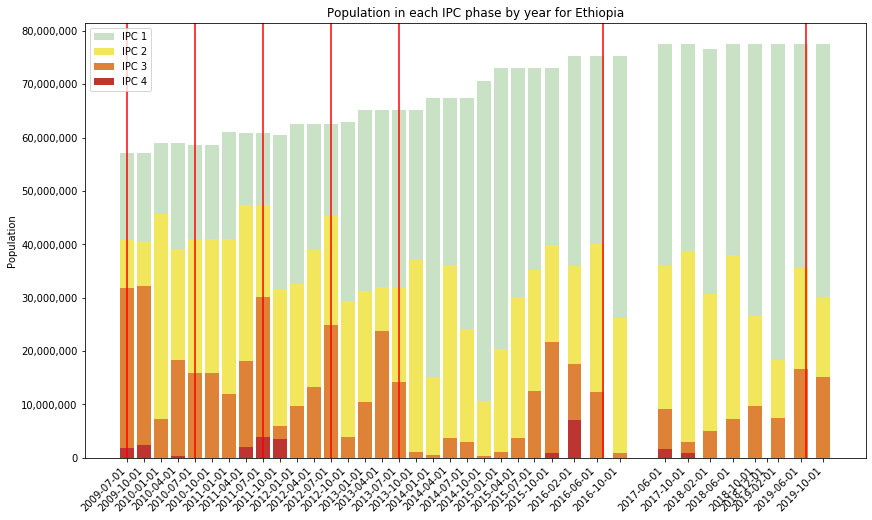

In [62]:
color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
fig, ax = plt.subplots(figsize=(14,8))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
width=75
p4 = plt.bar(national_grouped['date'], national_grouped['cs_4'], width=width, color=color_map[4])
p3 = plt.bar(national_grouped['date'], national_grouped['cs_3'], width=width, color=color_map[3], 
            bottom=national_grouped['cs_4'])
p2 = plt.bar(national_grouped['date'], national_grouped['cs_2'], width=width, color=color_map[2],
            bottom=(national_grouped['cs_4']+national_grouped['cs_3']))
p1 = plt.bar(national_grouped['date'], national_grouped['cs_1'], width=width, color=color_map[1],
            bottom=(national_grouped['cs_4']+national_grouped['cs_3']+national_grouped['cs_2']))

for year in trigger_years:
    plt.axvline(year, color='red')
#p5 = plt.plot(total_pop['date'], total_pop['perc_2_5'], color='red')
#p6 = plt.plot(total_pop['date'], total_pop['perc_10'], color='blue')
#p7 = plt.plot(total_pop['date'], total_pop['perc_20'], color='black')


plt.ylabel('Population')
plt.title('Population in each IPC phase by year for Ethiopia')
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('IPC 1', 'IPC 2', 'IPC 3', 'IPC 4'))

plt.xticks(grouped['date'].unique(), rotation=45, ha="right")

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.show()

In [78]:
national_grouped = national_grouped[national_grouped['date'] != '2018-12-01']

ConversionError: Failed to convert value(s) to axis units: '2009-07-01'

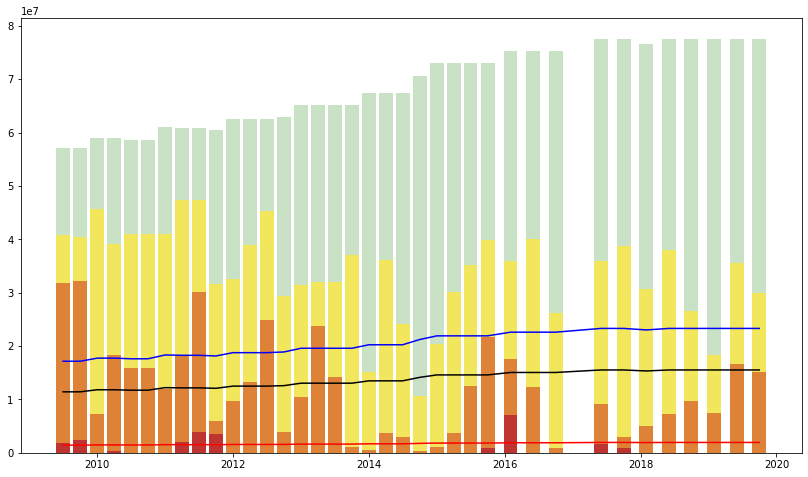

In [50]:
color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
trigger_years = ['2009-07-01', '2009-10-10', '2011-04-01', '2011-07-01', '2016-02-01', '2017-06-01']
fig, ax = plt.subplots(figsize=(14,8))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
width=75
p4 = plt.bar(national_grouped['date'], national_grouped['cs_4'], width=width, color=color_map[4])
p3 = plt.bar(national_grouped['date'], national_grouped['cs_3'], width=width, color=color_map[3], 
            bottom=national_grouped['cs_4'])
p2 = plt.bar(national_grouped['date'], national_grouped['cs_2'], width=width, color=color_map[2],
            bottom=(national_grouped['cs_4']+national_grouped['cs_3']))
p1 = plt.bar(national_grouped['date'], national_grouped['cs_1'], width=width, color=color_map[1],
            bottom=(national_grouped['cs_4']+national_grouped['cs_3']+national_grouped['cs_2']))

p5 = plt.plot(national_grouped['date'], national_grouped['total_pop']/40, color='red')
p6 = plt.plot(national_grouped['date'], national_grouped['total_pop']/3.33, color='blue')
p7 = plt.plot(national_grouped['date'], national_grouped['total_pop']/5, color='black')

for year in trigger_years:
    plt.axvline(year, color='red')


plt.ylabel('Population')
plt.title('Population in each IPC phase by year for Ethiopia\n Trigger at (20%)')
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0]), ('IPC 1', 'IPC 2', 'IPC 3', 'IPC 4', '2.5 %', '30 %', '20 %'))

plt.xticks(grouped['date'].unique(), rotation=45, ha="right")

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.show()

KeyError: 'CS'

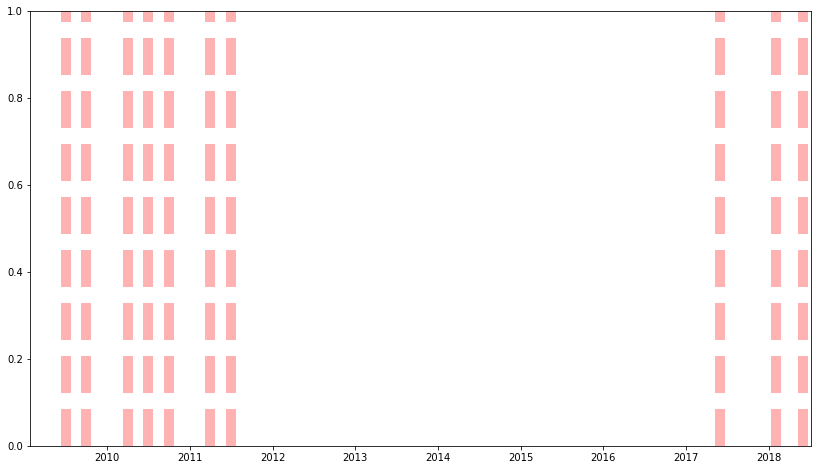

In [51]:
thresholds = ['2009-07-01', '2009-10-01', '2010-04-01', '2010-07-01','2010-10-01','2011-04-01', 
              '2011-07-01','2017-06-01', '2018-02-01','2018-06-01']
color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
fig, ax = plt.subplots(figsize=(14,8))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
width=75
for t in thresholds:
    plt.axvline(pd.to_datetime(t), color='red', lw=10, ls='--', alpha=0.3)
p1 = plt.bar(grouped['date'].loc[grouped['CS']==1], grouped['T'].loc[grouped['CS']==1], width=width, color=color_map[1])
p2 = plt.bar(grouped['date'].loc[grouped['CS']==2], grouped['T'].loc[grouped['CS']==2], width=width, color=color_map[2])
p3 = plt.bar(grouped['date'].loc[grouped['CS']==3], grouped['T'].loc[grouped['CS']==3], width=width, color=color_map[3])
p4 = plt.bar(grouped['date'].loc[grouped['CS']==4], grouped['T'].loc[grouped['CS']==4], width=width, color=color_map[4])
p5 = plt.plot(total_pop['date'], total_pop['perc_2_5'], color='red')
p6 = plt.plot(total_pop['date'], total_pop['perc_20'], color='black')


plt.ylabel('Population')
plt.title('Population in each IPC phase by year for Chad with Triggers')
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('IPC 1', 'IPC 2', 'IPC 3', 'IPC 4', '2.5 %', '20 %'))

plt.xticks(grouped['date'].unique(), rotation=45, ha='right')

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#ax.ticklabel_format(useOffset=False)

plt.show()

In [52]:
#shapefile = '../FEWSNET/Southern Africa/SA_'+d+'_CS.shp'
    #Read shapefile using Geopandas
#   gdf = gpd.read_file(shapefile)
#    gdf['color'] = gdf['CS'].apply(lambda x: set_color(x))
#    gdf.plot(color = gdf['color'])
combined.head()

NameError: name 'combined' is not defined

In [149]:
for row in converted.iterrows():
    print(row)

(0, ADMIN0            Chad
ADMIN1           Guera
ADMIN2        Mangalme
date            201101
CS                   2
CS201110_P         NaN
Name: 0, dtype: object)
(1, ADMIN0            Chad
ADMIN1         Salamat
ADMIN2        Aboudeia
date            201101
CS                   2
CS201110_P         NaN
Name: 1, dtype: object)
(2, ADMIN0             Chad
ADMIN1        Wadi Fira
ADMIN2          Biltine
date             201101
CS                    2
CS201110_P          NaN
Name: 2, dtype: object)
(4, ADMIN0           Chad
ADMIN1        Ouaddai
ADMIN2          Ouara
date           201101
CS                  2
CS201110_P        NaN
Name: 4, dtype: object)
(5, ADMIN0          Chad
ADMIN1         Kanem
ADMIN2         Kanem
date          201101
CS                 2
CS201110_P       NaN
Name: 5, dtype: object)
(6, ADMIN0                      Chad
ADMIN1             Barh el Gazel
ADMIN2        Barh el Gazel Nord
date                      201101
CS                             2
CS201110_P   

Name: 7, dtype: object)
(8, ADMIN0          Chad
ADMIN1         Guera
ADMIN2         Guera
date          201910
CS                 1
CS201110_P       NaN
Name: 8, dtype: object)
(9, ADMIN0             Chad
ADMIN1            Guera
ADMIN2        Abtouyour
date             201910
CS                    1
CS201110_P          NaN
Name: 9, dtype: object)
(10, ADMIN0                     Chad
ADMIN1        Logone Occidental
ADMIN2                    Dodje
date                     201910
CS                            1
CS201110_P                  NaN
Name: 10, dtype: object)
(11, ADMIN0                     Chad
ADMIN1        Logone Occidental
ADMIN2                  Lac Wey
date                     201910
CS                            1
CS201110_P                  NaN
Name: 11, dtype: object)
(12, ADMIN0                  Chad
ADMIN1        Chari-Baguirmi
ADMIN2              Baguirmi
date                  201910
CS                         1
CS201110_P               NaN
Name: 12, dtype: object)
(1

In [152]:
grouped.loc[grouped['CS']==3]

,date,CS,ADMIN2
3,201104,3,6
6,201107,3,2
34,201706,3,1
39,201806,3,1


In [153]:
df.loc[df['CS']==3]

,CS,CS201110_P,HA0,date,geometry
4,3.000,nan,nan,201104,"POLYGON ((16.82669 23.06833, 16.82722 23.06800..."
7,3.000,nan,nan,201107,"MULTIPOLYGON (((2.83221 15.35455, 2.84124 15.3..."
17,3.000,nan,0.000,201204,"MULTIPOLYGON (((20.06103 14.16966, 20.06201 14..."
18,3.000,nan,1.000,201204,"POLYGON ((-7.98768 19.72546, -9.14696 17.28808..."
22,3.000,nan,0.000,201207,"MULTIPOLYGON (((-7.65906 15.49917, -7.64795 15..."
23,3.000,nan,1.000,201207,"MULTIPOLYGON (((-7.77980 14.29640, -7.70789 14..."
33,3.000,nan,0.000,201304,"MULTIPOLYGON (((13.92498 13.10059, 13.93739 13..."
39,3.000,nan,0.000,201307,"MULTIPOLYGON (((13.92498 13.10059, 13.93739 13..."
47,3.000,nan,0.000,201401,"MULTIPOLYGON (((13.92498 13.10059, 13.93739 13..."
52,3.000,nan,0.000,201404,"MULTIPOLYGON (((13.92498 13.10059, 13.93739 13..."


In [123]:
t = converted.loc[(converted['date']=='201307')&(converted['ADMIN2'].astype(str)!='nan')]
t['ADMIN2'].unique().size

68

In [124]:
# Next steps
# Extend time series
# Add drought events
# Add threshold (proposed)
# Add food prices
# Add total population

,ADMIN0,ADMIN1,ADMIN2,date,CS,CS201110_P
35,Chad,Guera,Mangalme,201307,1,nan
